In [ ]:
#De La Huerta Avalos Gerardo Cristóbal
#2021630243
#5BM1
#entrenamiento por epocas
#Ephocs para el entrenamiento: 100    Learning rate del optimizador: 0.03

#Hiperparámetros de la red neuronal
#learning rate: 0.01

#Menor Loss: 0.0029 -> epoca 92
#Ultimo loss obtenido : Loss: 0.0523 -> epoca 100

#batch size: 64

# Entrenamiento de una red neuronal

Al entrenar una red buscamos que ésta tenga un comportamiendo presumiblemente adecuado y observable en un conjunto de datos. Es decír a partir del conjunto de ejemplos esperamos que la red aprenda una función $f$ tal que la salida de la red imite el patrón en los datos. En nuestro caso, al utilizar el conjunto de entrenamiento MNIST esperamos que la función aprendida provea como salida el número al cual corresponde la imagen de entrada.

<img src="archivos/function_approx.png">

Imagen tomada de [1]



## Retropropagación y Autograd

Pytorch provee el módulo *autograd* para calcular los gradientes, y si, !nos evita estar calculando las derivadas! Esto lo realiza a partir de mantener en la vista todas las operaciones que se ejecutan sobre los tensores.

Si deseas asegurarte que autograd siga a un tensor especificamos *requires_grad*. Esto se puede hacer en la creación o en cualquier momento. 

Veamos el siguiente código de ejemplo:

```python
# especificamos que la variable x es seguida por autograd
x = torch.zeros(1, requires_grad=True)
# si en algún momento desamos que temporalmente se deje de seguir el tensor usamos
>>> with torch.no_grad():
...     y = x * 2
# establecemos de nuevo el seguimiento
>>> y.requires_grad
```

Si queremos eliminar autograd de todos los tensores usamos `torch.set_grad_enabled(True|False)`.


Ahora bien, para calcular los gradientes simplemente usamos el método *backward()*. Por ejemplo para un tensor *cualquiera* hacemos *z.backward()*

Veamos a continuación el uso del gradiente.

In [1]:
# importamos paquetes
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

<Figure size 640x480 with 0 Axes>

In [2]:
# especificamos que el tensor x es seguido por autograd 
x = torch.randn(4, requires_grad=True)
print(x)

tensor([-0.1421,  1.0940,  0.7406, -0.7400], requires_grad=True)


In [3]:
# generamos un nuevo tensor a partir de x
# por ejemplo elevemos al cuadrado la variable x
y = x**2
print(y)

tensor([0.0202, 1.1968, 0.5484, 0.5476], grad_fn=<PowBackward0>)


In [4]:
## con grad_fn observamos la operación que generó y, es decir una operación potencia (pow)
print(y.grad_fn)


In [5]:
# De esta forma es posible saber las operaciónes que generan cada tensor, y por tanto, es posible calcular el gradiente.
# Hagamos ahora una operación de media
z = y.mean()
print(z)

tensor(0.5783, grad_fn=<MeanBackward0>)


In [6]:
# hasta este momento los gradientes son cero
print(x.grad)

None


Para calcular los gradientes es necesario llamar al método *.backward* sobre la variable. Supongamos sobre *z*. Esto calcula el gradiente de z con respecto de x.

El gradiente analítico de las operaciónes que hicimos es:
$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

Ahora comprobemos

In [7]:
z.backward()
print(x.grad)

print(x/2)

tensor([-0.0711,  0.5470,  0.3703, -0.3700])
tensor([-0.0711,  0.5470,  0.3703, -0.3700], grad_fn=<DivBackward0>)


## Conjunto de datos y red neuronal

Ahora descargemos los datos y generemos una red tal cual lo vimos en el notebook anterior. 

In [8]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.Normalize([0.5],[0.5])
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [9]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('relu2', nn.ReLU()),
                      ('relu3', nn.ReLU()),
                      ('relu4', nn.ReLU()),
                      ('relu5', nn.ReLU()),
                      ('relu6', nn.ReLU()),
                      ('relu7', nn.ReLU()),
                      ('relu8', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu5', nn.ReLU()),
                      ('relu6', nn.ReLU()),
                      ('relu7', nn.ReLU()),
                      ('relu8', nn.ReLU()),
                      ('relu9', nn.ReLU()),
                      ('relu10', nn.ReLU()),
                      ('relu11', nn.ReLU()),
                      ('relu12', nn.ReLU()),
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

# NOTA solo calcularemos los logits y definiremos la perdida a partir de ellos

## Entrenamiento de la red

Lo primero que definiremos será la función de pérdida (loss) que es nombrada en pytorch como **criterion**. En este ejemplo estamos utilizando softmax, asi que definimos el criterio como *criterion = nn.CrossEntropyLoss()*. Más tarde, en el entrenamiento, veremos que *loss = criterion(output, targets)* calcula la pérdida.

Lo segundo que definiremos será el optimizador, para este ejemplo usaremos SGD (stochastic gradient descent). Simplemente llamamos a *torch.optim.SGD* y le pasamos los parámetros de la red y el lerning rate. 


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Antes de relizar el entrenamiento completo haremos un paso del aprendizaje. Este paso se compone de las siguientes tareas:

1. Realizar un pase frontal de la red
2. Utilizar los logits para calcular la pérdida
3. Realizar la retropropagación para calcular los gradientes.
4. Actualizar los pesos usando el optimizador.

Veamos el ejemplo


In [11]:
print('Initial weights - ', model.fc1.weight)


Initial weights -  Parameter containing:
tensor([[ 0.0327, -0.0276,  0.0006,  ...,  0.0252,  0.0296,  0.0013],
        [ 0.0179,  0.0266,  0.0008,  ...,  0.0102, -0.0095, -0.0140],
        [-0.0051,  0.0199,  0.0199,  ...,  0.0335, -0.0074, -0.0349],
        ...,
        [-0.0054, -0.0113, -0.0123,  ..., -0.0344, -0.0029,  0.0333],
        [ 0.0337, -0.0138,  0.0091,  ..., -0.0058, -0.0157, -0.0287],
        [-0.0045,  0.0126, -0.0229,  ...,  0.0337,  0.0130, -0.0224]],
       requires_grad=True)


In [12]:
images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Limpiar los gradientes por que se acumulan
optimizer.zero_grad()

# Pase hacia adelante
output = model.forward(images)
# Perdida
loss = criterion(output, labels)
# Pase de reversa
loss.backward()
print('Gradient -', model.fc1.weight.grad)
# Actualiza los pesos de acuerdo a un paso del optimizador
optimizer.step()

Gradient - tensor([[-2.9855e-03, -2.9855e-03, -2.9855e-03,  ..., -2.9855e-03,
         -2.9855e-03, -2.9855e-03],
        [-2.9929e-03, -2.9929e-03, -2.9929e-03,  ..., -2.9929e-03,
         -2.9929e-03, -2.9929e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-6.9240e-03, -6.9240e-03, -6.9240e-03,  ..., -6.9240e-03,
         -6.9240e-03, -6.9240e-03],
        [-3.1320e-05, -3.1320e-05, -3.1320e-05,  ..., -3.1320e-05,
         -3.1320e-05, -3.1320e-05]])


In [13]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 0.0327, -0.0276,  0.0006,  ...,  0.0252,  0.0297,  0.0013],
        [ 0.0179,  0.0266,  0.0009,  ...,  0.0103, -0.0095, -0.0139],
        [-0.0051,  0.0199,  0.0199,  ...,  0.0335, -0.0074, -0.0349],
        ...,
        [-0.0054, -0.0113, -0.0123,  ..., -0.0344, -0.0029,  0.0333],
        [ 0.0338, -0.0138,  0.0092,  ..., -0.0057, -0.0156, -0.0286],
        [-0.0045,  0.0126, -0.0229,  ...,  0.0337,  0.0130, -0.0224]],
       requires_grad=True)


## Entrenamiento por épocas

Ahora si, entrenemos la red por varias épocas. Para ello programaremos el algoritmo de gradiente descendente que de forma general funciona con los siguientes pasos:

- Para un número de *épocas*:
    - Para cada *lote* en el conjunto de datos:
        - Salida = Red predice usando el *lote*
        - Calcular *pérdida* a partir de la *salida* y de las *etiquetas* reales
        - Error = Retropropagación a partir de la *pérdida*
        - Actualizar pesos
        
    

In [14]:
# configuración del optimizador
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [15]:
# hiperparámetro: número de épocas
epochs = 100
print_every = 40
steps = 0

for e in range(epochs):
    running_loss = 0
    # en cada iteración del for cargamos un batch
    for images, labels in iter(trainloader):
        steps += 1
        # Aplanar las imagenes de MNIST
        images.resize_(images.size()[0], 784)
        
        # Reiniciar el gradiente
        optimizer.zero_grad()
        
        # Pase frontal de la red
        output = model.forward(images)
        
        # Estimar la perdida
        loss = criterion(output, labels)
        
        # Backprogation
        loss.backward()
        
        # Actualizamos los pesos
        optimizer.step()
        
        # Guardamos la perdida para control del entrenamiento
        running_loss += loss.item()
        
        # imprimimos cada 40 lotes
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/100...  Loss: 2.2853
Epoch: 1/100...  Loss: 2.2567
Epoch: 1/100...  Loss: 2.2279
Epoch: 1/100...  Loss: 2.2086
Epoch: 1/100...  Loss: 2.1781
Epoch: 1/100...  Loss: 2.1488
Epoch: 1/100...  Loss: 2.1092
Epoch: 1/100...  Loss: 2.0761
Epoch: 1/100...  Loss: 2.0377
Epoch: 1/100...  Loss: 1.9853
Epoch: 1/100...  Loss: 1.9494
Epoch: 1/100...  Loss: 1.9083
Epoch: 1/100...  Loss: 1.8265
Epoch: 1/100...  Loss: 1.7757
Epoch: 1/100...  Loss: 1.7300
Epoch: 1/100...  Loss: 1.6500
Epoch: 1/100...  Loss: 1.5972
Epoch: 1/100...  Loss: 1.5311
Epoch: 1/100...  Loss: 1.4556
Epoch: 1/100...  Loss: 1.3956
Epoch: 1/100...  Loss: 1.3476
Epoch: 1/100...  Loss: 1.2588
Epoch: 1/100...  Loss: 1.2023
Epoch: 2/100...  Loss: 0.6130
Epoch: 2/100...  Loss: 1.0988
Epoch: 2/100...  Loss: 1.0564
Epoch: 2/100...  Loss: 1.0216
Epoch: 2/100...  Loss: 0.9951
Epoch: 2/100...  Loss: 0.9540
Epoch: 2/100...  Loss: 0.8824
Epoch: 2/100...  Loss: 0.8639
Epoch: 2/100...  Loss: 0.8332
Epoch: 2/100...  Loss: 0.8095
Epoch: 2/1

Epoch: 12/100...  Loss: 0.2638
Epoch: 12/100...  Loss: 0.2808
Epoch: 12/100...  Loss: 0.2895
Epoch: 12/100...  Loss: 0.2802
Epoch: 12/100...  Loss: 0.2917
Epoch: 12/100...  Loss: 0.2625
Epoch: 12/100...  Loss: 0.2950
Epoch: 12/100...  Loss: 0.2659
Epoch: 12/100...  Loss: 0.2785
Epoch: 13/100...  Loss: 0.1555
Epoch: 13/100...  Loss: 0.2801
Epoch: 13/100...  Loss: 0.2523
Epoch: 13/100...  Loss: 0.2910
Epoch: 13/100...  Loss: 0.2818
Epoch: 13/100...  Loss: 0.2771
Epoch: 13/100...  Loss: 0.2797
Epoch: 13/100...  Loss: 0.2730
Epoch: 13/100...  Loss: 0.2599
Epoch: 13/100...  Loss: 0.2929
Epoch: 13/100...  Loss: 0.2541
Epoch: 13/100...  Loss: 0.2791
Epoch: 13/100...  Loss: 0.2667
Epoch: 13/100...  Loss: 0.2612
Epoch: 13/100...  Loss: 0.2690
Epoch: 13/100...  Loss: 0.2823
Epoch: 13/100...  Loss: 0.2442
Epoch: 13/100...  Loss: 0.2825
Epoch: 13/100...  Loss: 0.2942
Epoch: 13/100...  Loss: 0.2486
Epoch: 13/100...  Loss: 0.2705
Epoch: 13/100...  Loss: 0.2734
Epoch: 13/100...  Loss: 0.2894
Epoch: 1

Epoch: 23/100...  Loss: 0.2173
Epoch: 23/100...  Loss: 0.1931
Epoch: 24/100...  Loss: 0.1309
Epoch: 24/100...  Loss: 0.1969
Epoch: 24/100...  Loss: 0.1885
Epoch: 24/100...  Loss: 0.2168
Epoch: 24/100...  Loss: 0.2000
Epoch: 24/100...  Loss: 0.1873
Epoch: 24/100...  Loss: 0.2228
Epoch: 24/100...  Loss: 0.2004
Epoch: 24/100...  Loss: 0.2066
Epoch: 24/100...  Loss: 0.1995
Epoch: 24/100...  Loss: 0.2259
Epoch: 24/100...  Loss: 0.1965
Epoch: 24/100...  Loss: 0.2167
Epoch: 24/100...  Loss: 0.2033
Epoch: 24/100...  Loss: 0.1916
Epoch: 24/100...  Loss: 0.2005
Epoch: 24/100...  Loss: 0.2212
Epoch: 24/100...  Loss: 0.2120
Epoch: 24/100...  Loss: 0.2127
Epoch: 24/100...  Loss: 0.2151
Epoch: 24/100...  Loss: 0.2064
Epoch: 24/100...  Loss: 0.2035
Epoch: 24/100...  Loss: 0.1833
Epoch: 25/100...  Loss: 0.0393
Epoch: 25/100...  Loss: 0.2154
Epoch: 25/100...  Loss: 0.2090
Epoch: 25/100...  Loss: 0.2420
Epoch: 25/100...  Loss: 0.2089
Epoch: 25/100...  Loss: 0.1908
Epoch: 25/100...  Loss: 0.2113
Epoch: 2

Epoch: 35/100...  Loss: 0.1444
Epoch: 35/100...  Loss: 0.1782
Epoch: 35/100...  Loss: 0.1696
Epoch: 35/100...  Loss: 0.1475
Epoch: 35/100...  Loss: 0.1592
Epoch: 35/100...  Loss: 0.1563
Epoch: 35/100...  Loss: 0.1597
Epoch: 35/100...  Loss: 0.1782
Epoch: 35/100...  Loss: 0.1583
Epoch: 35/100...  Loss: 0.1503
Epoch: 35/100...  Loss: 0.1501
Epoch: 35/100...  Loss: 0.1552
Epoch: 35/100...  Loss: 0.1681
Epoch: 35/100...  Loss: 0.1606
Epoch: 35/100...  Loss: 0.1951
Epoch: 35/100...  Loss: 0.1693
Epoch: 35/100...  Loss: 0.1488
Epoch: 35/100...  Loss: 0.1651
Epoch: 36/100...  Loss: 0.0460
Epoch: 36/100...  Loss: 0.1466
Epoch: 36/100...  Loss: 0.1578
Epoch: 36/100...  Loss: 0.1543
Epoch: 36/100...  Loss: 0.1607
Epoch: 36/100...  Loss: 0.1685
Epoch: 36/100...  Loss: 0.1605
Epoch: 36/100...  Loss: 0.1523
Epoch: 36/100...  Loss: 0.1549
Epoch: 36/100...  Loss: 0.1395
Epoch: 36/100...  Loss: 0.1710
Epoch: 36/100...  Loss: 0.1651
Epoch: 36/100...  Loss: 0.1482
Epoch: 36/100...  Loss: 0.1591
Epoch: 3

Epoch: 46/100...  Loss: 0.1479
Epoch: 46/100...  Loss: 0.1302
Epoch: 46/100...  Loss: 0.1680
Epoch: 46/100...  Loss: 0.1341
Epoch: 46/100...  Loss: 0.1082
Epoch: 46/100...  Loss: 0.1223
Epoch: 46/100...  Loss: 0.1289
Epoch: 46/100...  Loss: 0.1227
Epoch: 46/100...  Loss: 0.1269
Epoch: 46/100...  Loss: 0.1246
Epoch: 46/100...  Loss: 0.1297
Epoch: 47/100...  Loss: 0.0386
Epoch: 47/100...  Loss: 0.1397
Epoch: 47/100...  Loss: 0.1209
Epoch: 47/100...  Loss: 0.1214
Epoch: 47/100...  Loss: 0.1419
Epoch: 47/100...  Loss: 0.1256
Epoch: 47/100...  Loss: 0.1209
Epoch: 47/100...  Loss: 0.1176
Epoch: 47/100...  Loss: 0.1307
Epoch: 47/100...  Loss: 0.1139
Epoch: 47/100...  Loss: 0.1324
Epoch: 47/100...  Loss: 0.1191
Epoch: 47/100...  Loss: 0.1518
Epoch: 47/100...  Loss: 0.1259
Epoch: 47/100...  Loss: 0.1375
Epoch: 47/100...  Loss: 0.1198
Epoch: 47/100...  Loss: 0.1141
Epoch: 47/100...  Loss: 0.1378
Epoch: 47/100...  Loss: 0.1197
Epoch: 47/100...  Loss: 0.1187
Epoch: 47/100...  Loss: 0.1320
Epoch: 4

Epoch: 57/100...  Loss: 0.0932
Epoch: 57/100...  Loss: 0.1003
Epoch: 57/100...  Loss: 0.1106
Epoch: 57/100...  Loss: 0.0942
Epoch: 58/100...  Loss: 0.0345
Epoch: 58/100...  Loss: 0.1124
Epoch: 58/100...  Loss: 0.1234
Epoch: 58/100...  Loss: 0.1213
Epoch: 58/100...  Loss: 0.1180
Epoch: 58/100...  Loss: 0.1120
Epoch: 58/100...  Loss: 0.1181
Epoch: 58/100...  Loss: 0.0976
Epoch: 58/100...  Loss: 0.1001
Epoch: 58/100...  Loss: 0.1167
Epoch: 58/100...  Loss: 0.1058
Epoch: 58/100...  Loss: 0.0868
Epoch: 58/100...  Loss: 0.0957
Epoch: 58/100...  Loss: 0.0964
Epoch: 58/100...  Loss: 0.1002
Epoch: 58/100...  Loss: 0.1118
Epoch: 58/100...  Loss: 0.1161
Epoch: 58/100...  Loss: 0.0956
Epoch: 58/100...  Loss: 0.1012
Epoch: 58/100...  Loss: 0.0877
Epoch: 58/100...  Loss: 0.1163
Epoch: 58/100...  Loss: 0.0988
Epoch: 58/100...  Loss: 0.0879
Epoch: 58/100...  Loss: 0.1138
Epoch: 59/100...  Loss: 0.0874
Epoch: 59/100...  Loss: 0.1136
Epoch: 59/100...  Loss: 0.1067
Epoch: 59/100...  Loss: 0.1020
Epoch: 5

Epoch: 69/100...  Loss: 0.0814
Epoch: 69/100...  Loss: 0.0812
Epoch: 69/100...  Loss: 0.1045
Epoch: 69/100...  Loss: 0.0946
Epoch: 69/100...  Loss: 0.1039
Epoch: 69/100...  Loss: 0.0782
Epoch: 69/100...  Loss: 0.0804
Epoch: 69/100...  Loss: 0.0851
Epoch: 69/100...  Loss: 0.0931
Epoch: 69/100...  Loss: 0.0854
Epoch: 69/100...  Loss: 0.0835
Epoch: 69/100...  Loss: 0.0781
Epoch: 69/100...  Loss: 0.1027
Epoch: 69/100...  Loss: 0.0979
Epoch: 69/100...  Loss: 0.0852
Epoch: 69/100...  Loss: 0.0852
Epoch: 69/100...  Loss: 0.1049
Epoch: 69/100...  Loss: 0.0977
Epoch: 69/100...  Loss: 0.0857
Epoch: 69/100...  Loss: 0.0903
Epoch: 69/100...  Loss: 0.0844
Epoch: 70/100...  Loss: 0.0891
Epoch: 70/100...  Loss: 0.0985
Epoch: 70/100...  Loss: 0.0949
Epoch: 70/100...  Loss: 0.0860
Epoch: 70/100...  Loss: 0.0722
Epoch: 70/100...  Loss: 0.0891
Epoch: 70/100...  Loss: 0.0850
Epoch: 70/100...  Loss: 0.0867
Epoch: 70/100...  Loss: 0.0937
Epoch: 70/100...  Loss: 0.0799
Epoch: 70/100...  Loss: 0.0836
Epoch: 7

Epoch: 80/100...  Loss: 0.0808
Epoch: 80/100...  Loss: 0.0693
Epoch: 80/100...  Loss: 0.0758
Epoch: 80/100...  Loss: 0.0811
Epoch: 80/100...  Loss: 0.0691
Epoch: 80/100...  Loss: 0.0821
Epoch: 80/100...  Loss: 0.0685
Epoch: 80/100...  Loss: 0.0787
Epoch: 80/100...  Loss: 0.0747
Epoch: 80/100...  Loss: 0.0749
Epoch: 80/100...  Loss: 0.0634
Epoch: 80/100...  Loss: 0.0913
Epoch: 80/100...  Loss: 0.0866
Epoch: 80/100...  Loss: 0.0679
Epoch: 81/100...  Loss: 0.0777
Epoch: 81/100...  Loss: 0.0730
Epoch: 81/100...  Loss: 0.0699
Epoch: 81/100...  Loss: 0.0681
Epoch: 81/100...  Loss: 0.0727
Epoch: 81/100...  Loss: 0.0777
Epoch: 81/100...  Loss: 0.0680
Epoch: 81/100...  Loss: 0.0834
Epoch: 81/100...  Loss: 0.0842
Epoch: 81/100...  Loss: 0.0731
Epoch: 81/100...  Loss: 0.0693
Epoch: 81/100...  Loss: 0.0769
Epoch: 81/100...  Loss: 0.0844
Epoch: 81/100...  Loss: 0.0755
Epoch: 81/100...  Loss: 0.0744
Epoch: 81/100...  Loss: 0.0664
Epoch: 81/100...  Loss: 0.0758
Epoch: 81/100...  Loss: 0.0696
Epoch: 8

Epoch: 91/100...  Loss: 0.0570
Epoch: 91/100...  Loss: 0.0619
Epoch: 91/100...  Loss: 0.0564
Epoch: 91/100...  Loss: 0.0706
Epoch: 91/100...  Loss: 0.0740
Epoch: 91/100...  Loss: 0.0757
Epoch: 92/100...  Loss: 0.0029
Epoch: 92/100...  Loss: 0.0553
Epoch: 92/100...  Loss: 0.0588
Epoch: 92/100...  Loss: 0.0602
Epoch: 92/100...  Loss: 0.0631
Epoch: 92/100...  Loss: 0.0603
Epoch: 92/100...  Loss: 0.0607
Epoch: 92/100...  Loss: 0.0523
Epoch: 92/100...  Loss: 0.0659
Epoch: 92/100...  Loss: 0.0854
Epoch: 92/100...  Loss: 0.0706
Epoch: 92/100...  Loss: 0.0647
Epoch: 92/100...  Loss: 0.0715
Epoch: 92/100...  Loss: 0.0711
Epoch: 92/100...  Loss: 0.0603
Epoch: 92/100...  Loss: 0.0726
Epoch: 92/100...  Loss: 0.0708
Epoch: 92/100...  Loss: 0.0741
Epoch: 92/100...  Loss: 0.0640
Epoch: 92/100...  Loss: 0.0611
Epoch: 92/100...  Loss: 0.0684
Epoch: 92/100...  Loss: 0.0647
Epoch: 92/100...  Loss: 0.0638
Epoch: 92/100...  Loss: 0.0651
Epoch: 93/100...  Loss: 0.0417
Epoch: 93/100...  Loss: 0.0687
Epoch: 9

Finalmente, veamos que tan bien está clasificando la red

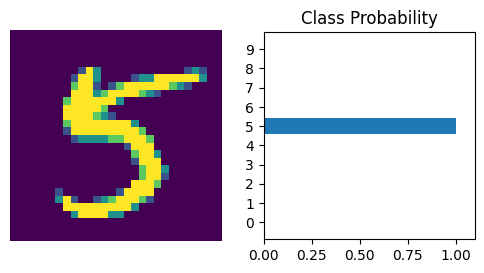

In [17]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)

## Referencias

[1] Udacity Computer vision Nanodegree